In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# 设置随机种子以确保结果可复现
tf.random.set_seed(42)
np.random.seed(42)

# 加载 MNIST 数据集
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# 数据预处理
train_images = train_images.reshape(-1, 28, 28, 1).astype('float32') / 255.0
test_images = test_images.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# 将标签转换为 one-hot 编码
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)


In [ ]:
# 创建位置编码
def positional_encoding(length, depth):
    depth = depth/2
    positions = np.arange(length)[:, np.newaxis]
    depths = np.arange(depth)[np.newaxis, :]/depth
    
    angle_rates = 1 / (10000**depths)
    angle_rads = positions * angle_rates
    
    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
    return tf.cast(pos_encoding, dtype=tf.float32)

# 多头注意力机制
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)
        
        self.dense = layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """将最后一维分割成 (num_heads, depth).
        转置结果使得形状为 (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        
        # 缩放点积注意力
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        
        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
        return output

# 缩放点积注意力
def scaled_dot_product_attention(q, k, v, mask):
    """计算注意力权重。
    q, k, v 必须具有匹配的前置维度。
    k, v 必须有匹配的倒数第二个维度，即：seq_len_k = seq_len_v。
    虽然 mask 根据其类型（填充或前瞻）有不同的形状，
    但是 mask 必须能进行广播转换以便求和。
    
    参数:
      q: 请求的形状 == (..., seq_len_q, depth)
      k: 主键的形状 == (..., seq_len_k, depth)
      v: 数值的形状 == (..., seq_len_v, depth_v)
      mask: Float 张量，其形状能转换成
            (..., seq_len_q, seq_len_k)。默认为None。
      
    返回:
      输出，注意力权重
    """
    
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    
    # 缩放 matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    # 将 mask 加入到缩放的张量上。
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
        
    # softmax 在最后一个轴(seq_len_k)上归一化，因此分数
    # 相加等于1。
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
    
    return output, attention_weights

# 点式前馈网络
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        layers.Dense(dff, activation='gelu'),  # (batch_size, seq_len, dff)
        layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

# 编码器层
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
        
    def call(self, x, training):
        # 多头注意力
        attn_output = self.mha(x, x, x, None)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        # 前馈网络
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        
        return out2

# 创建 Transformer 模型
class TransformerClassifier(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, image_size, patch_size, num_classes, dropout_rate=0.1):
        super(TransformerClassifier, self).__init__()
        
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        self.d_model = d_model
        self.patch_dim = patch_size * patch_size * 1  # 计算每个patch的维度（通道数为1）
        
        # 分块嵌入
        self.projection = layers.Dense(d_model)
        self.position_embedding = positional_encoding(self.num_patches, d_model)
        
        # Transformer 编码器层
        self.encoder_layers = [EncoderLayer(d_model, num_heads, dff, dropout_rate) 
                              for _ in range(num_layers)]
        
        # 分类头
        self.global_pool = layers.GlobalAveragePooling1D()
        self.final_layer = layers.Dense(num_classes, activation='softmax')
        
        # Dropout 层
        self.dropout = layers.Dropout(dropout_rate)
        
    def call(self, x, training):
        # 将图像分块并嵌入
        batch_size = tf.shape(x)[0]
        x = tf.reshape(x, [batch_size, self.num_patches, self.patch_dim])  # 使用预计算的patch_dim
        x = self.projection(x)
        
        # 添加位置编码
        x += self.position_embedding
        
        # 通过 Transformer 编码器层
        x = self.dropout(x, training=training)
        for layer in self.encoder_layers:
            x = layer(x, training=training)
        
        # 分类头
        x = self.global_pool(x)
        output = self.final_layer(x)
        
        return output

Epoch 1/10
843/844 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2289 - loss: 2.1269
Epoch 1: val_accuracy improved from -inf to 0.77767, saving model to best_model.h5


844/844 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.2293 - loss: 2.1259 - val_accuracy: 0.7777 - val_loss: 0.7030
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7353 - loss: 0.8141
Epoch 2: val_accuracy improved from 0.77767 to 0.88583, saving model to best_model.h5


844/844 ━━━━━━━━━━━━━━━━━━━━ 58s 69ms/step - accuracy: 0.7353 - loss: 0.8140 - val_accuracy: 0.8858 - val_loss: 0.3571
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8343 - loss: 0.5156
Epoch 3: val_accuracy improved from 0.88583 to 0.90883, saving model to best_model.h5


844/844 ━━━━━━━━━━━━━━━━━━━━ 5958s 7s/step - accuracy: 0.8343 - loss: 0.5156 - val_accuracy: 0.9088 - val_loss: 0.2750
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8670 - loss: 0.4107
Epoch 4: val_accuracy improved from 0.90883 to 0.92283, saving model to best_model.h5


844/844 ━━━━━━━━━━━━━━━━━━━━ 1328s 2s/step - accuracy: 0.8670 - loss: 0.4107 - val_accuracy: 0.9228 - val_loss: 0.2309
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8860 - loss: 0.3544
Epoch 5: val_accuracy improved from 0.92283 to 0.93583, saving model to best_model.h5


844/844 ━━━━━━━━━━━━━━━━━━━━ 3654s 4s/step - accuracy: 0.8860 - loss: 0.3544 - val_accuracy: 0.9358 - val_loss: 0.1990
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9010 - loss: 0.3086
Epoch 6: val_accuracy improved from 0.93583 to 0.94183, saving model to best_model.h5


844/844 ━━━━━━━━━━━━━━━━━━━━ 7330s 9s/step - accuracy: 0.9010 - loss: 0.3086 - val_accuracy: 0.9418 - val_loss: 0.1807
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9088 - loss: 0.2843
Epoch 7: val_accuracy improved from 0.94183 to 0.94917, saving model to best_model.h5


844/844 ━━━━━━━━━━━━━━━━━━━━ 3698s 4s/step - accuracy: 0.9088 - loss: 0.2843 - val_accuracy: 0.9492 - val_loss: 0.1603
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9174 - loss: 0.2585
Epoch 8: val_accuracy improved from 0.94917 to 0.95267, saving model to best_model.h5


844/844 ━━━━━━━━━━━━━━━━━━━━ 1004s 1s/step - accuracy: 0.9174 - loss: 0.2585 - val_accuracy: 0.9527 - val_loss: 0.1498
Epoch 9/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9227 - loss: 0.2421
Epoch 9: val_accuracy improved from 0.95267 to 0.95567, saving model to best_model.h5


844/844 ━━━━━━━━━━━━━━━━━━━━ 5670s 7s/step - accuracy: 0.9227 - loss: 0.2420 - val_accuracy: 0.9557 - val_loss: 0.1397
Epoch 10/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9289 - loss: 0.2242
Epoch 10: val_accuracy improved from 0.95567 to 0.95883, saving model to best_model.h5


844/844 ━━━━━━━━━━━━━━━━━━━━ 2405s 3s/step - accuracy: 0.9289 - loss: 0.2242 - val_accuracy: 0.9588 - val_loss: 0.1297
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9445 - loss: 0.1755
测试准确率: 95.17%


/var/folders/h9/x7x6hfzs1vlf0drg7p35zmj00000gn/T/ipykernel_52212/1748715905.py:58: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/h9/x7x6hfzs1vlf0drg7p35zmj00000gn/T/ipykernel_52212/1748715905.py:58: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/h9/x7x6hfzs1vlf0drg7p35zmj00000gn/T/ipykernel_52212/1748715905.py:58: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/h9/x7x6hfzs1vlf0drg7p35zmj00000gn/T/ipykernel_52212/1748715905.py:58: UserWarning: Glyph 30830 (\N{CJK UNIFIED IDEOGRAPH-786E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/h9/x7x6hfzs1vlf0drg7p35zmj00000gn/T/ipykernel_52212/1748715905.py:58: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/h9/x7x6

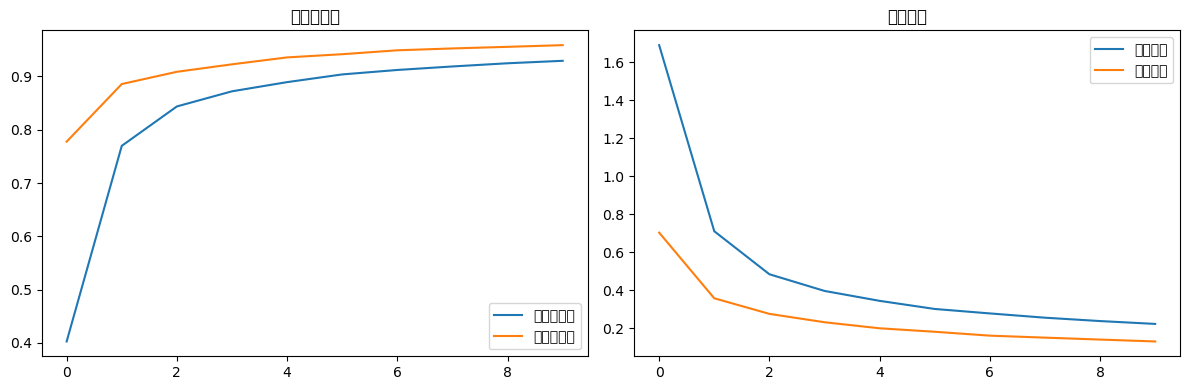

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


/var/folders/h9/x7x6hfzs1vlf0drg7p35zmj00000gn/T/ipykernel_52212/1748715905.py:72: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/h9/x7x6hfzs1vlf0drg7p35zmj00000gn/T/ipykernel_52212/1748715905.py:72: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/homebrew/anaconda3/envs/dl/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/envs/dl/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


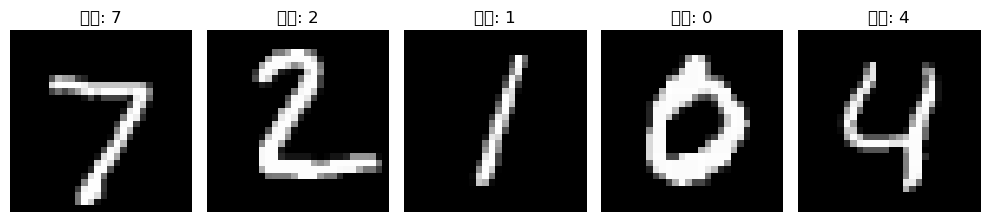

In [4]:

# 创建模型实例
model = TransformerClassifier(
    num_layers=2,
    d_model=64,
    num_heads=8,
    dff=128,
    image_size=28,
    patch_size=4,
    num_classes=10,
    dropout_rate=0.1
)

# 编译模型
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

# 设置回调函数
checkpoint_callback = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# 训练模型
history = model.fit(
    train_images, train_labels,
    batch_size=64,
    epochs=10,
    validation_split=0.1,
    callbacks=[checkpoint_callback]
)

# 加载最佳模型
model.load_weights('best_model.h5')

# 评估模型
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"测试准确率: {test_acc * 100:.2f}%")

# 绘制训练历史
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='训练准确率')
plt.plot(history.history['val_accuracy'], label='验证准确率')
plt.legend()
plt.title('模型准确率')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='训练损失')
plt.plot(history.history['val_loss'], label='验证损失')
plt.legend()
plt.title('模型损失')
plt.tight_layout()
plt.show()

# 预测示例
predictions = model.predict(test_images[:5])
predicted_labels = np.argmax(predictions, axis=1)

# 显示预测结果
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.title(f'预测: {predicted_labels[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()